In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.chdir('/content/gdrive/MyDrive/')

Mounted at /content/gdrive


In [15]:
%cd 'Hate_Speech/'

/content/gdrive/.shortcut-targets-by-id/1Xg2qEE6F52frkEE8GnTIFXnVNXPVLXOX/Hate_Speech


In [16]:
!pip install transformers

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import Transformer
from loss_func import CELoss, SupConLoss, DualLoss
from data_utils import load_data
from transformers import TFMT5Model, T5Tokenizer, logging, AutoTokenizer, AutoModel, AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import sys
import time
import random
from tqdm import tqdm
import logging
import argparse
from datetime import datetime
import numpy as np
import json
from functools import partial
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [18]:
class CELoss(nn.Module):

    def __init__(self):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        return self.xent_loss(outputs['predicts'], targets)

class ConLoss(nn.Module):

    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)
        # ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        return cl_loss

class SupConLoss(nn.Module):

    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)
        ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        return ce_loss + cl_loss

class AdversarialConLoss(nn.Module):
    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):

        ce_loss = self.xent_loss(outputs['predicts'], targets)
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)

        unnormalized_noise = normed_cls_feats.clone()
        norm = unnormalized_noise.norm(p=2, dim=-1)
        normalized_noise = unnormalized_noise / (norm.unsqueeze(dim=-1) + 1e-10)  # add 1e-10 to avoid Nan

        noise_norm = 0.5 #0.005
        alp = 0.5

        target_noise = noise_norm * normalized_noise
        noise_x_ = normed_cls_feats + target_noise
        noise_CEloss = self.xent_loss(noise_x_, targets)
        noise_scloss =self.nt_xent_loss(normed_cls_feats, noise_x_, targets)
        # noise_CEloss = F.nll_loss(F.log_softmax(self.fc(noise_x_), dim=1), data.y)

        #noise_loss = (1 - self.alpha) * noise_CEloss + self.alpha * noise_scloss

        scl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        total_loss = (1 - self.alpha) *(ce_loss + noise_CEloss)/2 + noise_scloss * self.alpha

        return  total_loss

class DualLoss(SupConLoss):

    def __init__(self, alpha, temp):
        super().__init__(alpha, temp)

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)

        normed_label_feats = F.normalize(outputs['label_feats'], dim=-1)
        normed_pos_label_feats = torch.gather(normed_label_feats, dim=1, index=targets.reshape(-1, 1, 1).expand(-1, 1, normed_label_feats.size(-1))).squeeze(1)
        ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss_1 = 0.5 * self.alpha * self.nt_xent_loss(normed_pos_label_feats, normed_cls_feats, targets)
        cl_loss_2 = 0.5 * self.alpha * self.nt_xent_loss(normed_cls_feats, normed_pos_label_feats, targets)
        return ce_loss + cl_loss_1 + cl_loss_2

In [19]:
class Instructor:

    def __init__(self, args, logger):
        self.args = args
        self.logger = logger
        self.logger.info('> creating model {}'.format(args.model_name))
        if args.model_name == 'xlm-roberta':
            # self.tokenizer = AutoTokenizer.from_pretrained('berta-base-multilingual-cased')
            self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            # self.tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

            # tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            # model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

            # base_model = AutoModel.from_pretrained('bert-base-multilingual-cased')
            base_model = AutoModel.from_pretrained("xlm-roberta-base")

            # base_model = TFMT5Model.from_pretrained('google/mt5-small')
            # self.tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

            # model = TFMT5Model.from_pretrained("google/mt5-small")
            # tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
        elif args.model_name == 'roberta':
            self.tokenizer = AutoTokenizer.from_pretrained('roberta-base-multilingual-cased', add_prefix_space=True)
            base_model = AutoModel.from_pretrained('roberta-base--multilingual-cased')
        elif args.model_name == 'mbert':
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', add_prefix_space=True)
            base_model = AutoModel.from_pretrained('bert-base-multilingual-cased')
        else:
            raise ValueError('unknown model')
        self.model = Transformer(base_model, args.num_classes, args.method)
        self.model.to(args.device)
        if args.device.type == 'cuda':
            self.logger.info('> cuda memory allocated: {}'.format(torch.cuda.memory_allocated(args.device.index)))
        self._print_args()

    def _print_args(self):
        self.logger.info('> training arguments:')
        for arg in vars(self.args):
            self.logger.info(f">>> {arg}: {getattr(self.args, arg)}")

    def _train(self, dataloader, criterion, optimizer):
        train_loss, n_correct, n_train = 0, 0, 0
        self.model.train()
        predictions, true_vals = [], []
        for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii=' >='):
            inputs = {k: v.to(self.args.device) for k, v in inputs.items()}
            targets = targets.to(self.args.device)
            outputs = self.model(**inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * targets.size(0)
            n_correct += (torch.argmax(outputs['predicts'], -1) == targets).sum().item()
            n_train += targets.size(0)

            predictions.append(outputs)
            true_vals.append(targets)

        return train_loss/n_train, n_correct/n_train, true_vals, predictions

    def _test(self, dataloader, criterion):
        test_loss, n_correct, n_test = 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            predictions, true_vals = [], []
            for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii=' >='):
                inputs = {k: v.to(self.args.device) for k, v in inputs.items()}
                targets = targets.to(self.args.device)
                outputs = self.model(**inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * targets.size(0)
                n_correct += (torch.argmax(outputs['predicts'], -1) == targets).sum().item()
                n_test += targets.size(0)
                predictions.append(outputs)
                true_vals.append(targets)
        return test_loss/n_test, n_correct/n_test, true_vals, predictions

    def run(self):
        train_dataloader, test_dataloader = load_data(dataset=self.args.dataset,
                                                      data_dir=self.args.data_dir,
                                                      tokenizer=self.tokenizer,
                                                      train_batch_size=self.args.train_batch_size,
                                                      test_batch_size=self.args.test_batch_size,
                                                      model_name=self.args.model_name,
                                                      method=self.args.method,
                                                      workers=0)

        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        if self.args.method == 'ce':
            criterion = CELoss()
        elif self.args.method == 'scl':
            criterion = SupConLoss(self.args.alpha, self.args.temp)
        elif self.args.method=='Adversarial':
             criterion = AdversarialConLoss(self.args.alpha, self.args.temp)
        elif self.args.method == 'cl':
            criterion =ConLoss(self.args.alpha, self.args.temp)
        elif self.args.method == 'dualcl':
            criterion = DualLoss(self.args.alpha, self.args.temp)
        else:
            raise ValueError('unknown method')
        optimizer = torch.optim.AdamW(_params, lr=self.args.lr, weight_decay=self.args.decay)
        best_loss, best_acc = 0, 0
        best_fscore = 0
        fscores_train, fscores_test = [], []
        for epoch in range(self.args.num_epoch):
            train_loss, train_acc, targets, outputs = self._train(train_dataloader, criterion, optimizer)
            pred = []
            for o in outputs:
                pred.append(torch.argmax(o['predicts'], -1).detach().cpu().numpy())
            predictions = np.concatenate(pred, axis=0)
            tt = []
            for t in targets:
                tt.append(t.detach().cpu().numpy())
            true_vals = np.concatenate(tt, axis=0)
            train_fscore = f1_score(true_vals, predictions, average='macro')
            fscores_train.append(train_fscore)
            print('----> train fscore:', train_fscore)
            print('Training phase\n', classification_report(predictions, true_vals, digits=4))
            test_loss, test_acc, targets, outputs = self._test(test_dataloader, criterion)
            pred = []
            for o in outputs:
                pred.append(torch.argmax(o['predicts'], -1).detach().cpu().numpy())
            predictions = np.concatenate(pred, axis=0)
            tt = []
            for t in targets:
                tt.append(t.detach().cpu().numpy())
            true_vals = np.concatenate(tt, axis=0)
            test_fscore = f1_score(true_vals, predictions, average='macro')
            fscores_test.append(test_fscore)
            print('----> test fscore:', test_fscore)
            print('Test phase\n', classification_report(predictions, true_vals, digits=4))
            if test_acc > best_acc or (test_acc == best_acc and test_loss < best_loss):
                best_acc, best_loss = test_acc, test_loss
            if test_fscore > best_fscore:
                best_fscore = test_fscore
            self.logger.info('{}/{} - {:.2f}%'.format(epoch+1, self.args.num_epoch, 100*(epoch+1)/self.args.num_epoch))
            #self.logger.info('[train] loss: {:.4f}, acc: {:.2f}'.format(train_loss, train_acc*100))
            #self.logger.info('[test] loss: {:.4f}, acc: {:.2f}'.format(test_loss, test_acc*100))
        #self.logger.info('best loss: {:.4f}, best acc: {:.2f}'.format(best_loss, best_acc*100))
        self.logger.info('best fscore: {:.4f}, best acc: {:.2f}'.format(best_fscore, best_acc*100))
        #self.logger.info('log saved: {}'.format(self.args.log_name))
        plt.plot(fscores_train, label='train')
        plt.plot(fscores_test, label='test')
        plt.legend()

In [20]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
num_classes = {'hs': 2, 'turkish': 2, 'arabic': 2, 'pc': 2, 'cr': 2}
''' Base '''
#settings
parser.add_argument('--data_dir', type=str, default='data')
parser.add_argument('--dataset', type=str, default='arabic', choices=num_classes.keys())
parser.add_argument('--model_name', type=str, default='mbert', choices=['bert', 'roberta','mbert','xlm-roberta'])
parser.add_argument('--method', type=str, default='Adversarial', choices=['ce', 'scl', 'dualcl','Adversarial'])
''' Optimization '''
parser.add_argument('--train_batch_size', type=int, default=16)
parser.add_argument('--test_batch_size', type=int, default=16)
parser.add_argument('--num_epoch', type=int, default=20)
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('--decay', type=float, default=0.01)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument('--temp', type=float, default=0.1)
''' Environment '''
parser.add_argument('--backend', default=False, action='store_true')
parser.add_argument('--timestamp', type=int, default='{:.0f}{:03}'.format(time.time(), random.randint(0, 999)))
parser.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
args = parser.parse_args()
args.num_classes = num_classes[args.dataset]
args.device = torch.device(args.device)
args.log_name = '{}_{}_{}_{}.log'.format(args.dataset, args.model_name, args.method, datetime.now().strftime('%Y-%m-%d_%H-%M-%S')[2:])
if not os.path.exists('logs'):
    os.mkdir('logs')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.addHandler(logging.FileHandler(os.path.join('logs', args.log_name)))

# **few-shot**

In [21]:
class MyDataset(Dataset):

    def __init__(self, raw_data, label_dict, tokenizer, model_name, method):
        label_list = ['positive', 'negative'] if method not in ['ce', 'scl'] else []
        sep_token = ['[SEP]'] if model_name == 'bert' else ['</s>']
        dataset = list()
        data=raw_data
        for i in raw_data.index:
            tokens = raw_data.text[i].split(' ')
            label_id = raw_data.hs[i]
            dataset.append((label_list + sep_token + tokens, label_id))
        self._dataset=dataset

    def __getitem__(self, index):
        return self._dataset[index]

    def __len__(self):
        return len(self._dataset)

def my_collate(batch, tokenizer, method, num_classes):
    tokens, label_ids = map(list, zip(*batch))
    text_ids = tokenizer(tokens,
                         padding=True,
                         truncation=True,
                         max_length=256,
                         is_split_into_words=True,
                         add_special_tokens=True,
                         return_tensors='pt')
    if method not in ['ce', 'scl']:
        positions = torch.zeros_like(text_ids['input_ids'])
        positions[:, num_classes:] = torch.arange(0, text_ids['input_ids'].size(1)-num_classes)
        text_ids['position_ids'] = positions
    return text_ids, torch.tensor(label_ids)

def load_data(dataset, data_dir, tokenizer, train_batch_size, test_batch_size, model_name, method, workers):
    global train_data
    global test_data
    global split_len
    if dataset == 'arabic':
        test_data = pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-mulki/L-HSAB.csv', sep = '\t')
        label_dict = {'normal': 0, 'hatful': 1}

    # load dataset .....................................................
    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-ousidhoum/ar_dataset.csv')
    pd_arabic['sentiment'][pd_arabic['sentiment']=='normal']=0
    pd_arabic['sentiment'][pd_arabic['sentiment']=='hateful']=1
    pd_arabic_n=pd_arabic[(pd_arabic['sentiment']==0) | (pd_arabic['sentiment']==1)]
    pd_arabic_n['text']=pd_arabic_n['tweet']
    pd_arabic_n['hs']=pd_arabic_n['sentiment']
    pd_arabic_n=pd_arabic_n[['text','hs']]
    pd_arabic_n.text =  pd_arabic_n.text.replace(np.NaN, regex=True)
    pd_arabic_n=pd_arabic_n.reset_index()


    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-mulki/L-HSAB.csv', sep = '\t')
    pd_arabic['Class'][pd_arabic['Class']=='normal']=0
    pd_arabic['Class'][pd_arabic['Class']=='hate']=1
    pd_arabic_m=pd_arabic[(pd_arabic['Class']==0) | (pd_arabic['Class']==1)]
    pd_arabic_m['text']=pd_arabic_m['Tweet']
    pd_arabic_m['hs']=pd_arabic_m['Class']
    pd_arabic_m=pd_arabic_m[['text','hs']]
    # X_test_sample=test_data.iloc[random.sample(range(0, len(test_data)), num_sample_test)];
    #pd_arabic_m.text =  pd_arabic_n.text.replace(np.NaN, regex=True)
    pd_arabic_m=pd_arabic_m.reset_index()

    #T3-HSAB-csv

    colnames=['tweet', 'label']
    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-haddad/M1_train_T_HSAB.csv')
    #pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-haddad/T3-HSAB.csv',names=colnames, header=None,sep=';')
    pd_arabic['label'][pd_arabic['label']=='normal']=0
    pd_arabic['label'][pd_arabic['label']=='hate']=1
    pd_arabic_t2=pd_arabic[(pd_arabic['label']==0) | (pd_arabic['label']==1)]
    pd_arabic_t2['text']=pd_arabic_t2['tweet']
    pd_arabic_t2['hs']=pd_arabic_t2['label']
    pd_arabic_t2=pd_arabic_t2[['text','hs']]
    pd_arabic_t2=pd_arabic_t2.reset_index()

    arbic = pd.concat([pd_arabic_n,pd_arabic_m,pd_arabic_t2])
    from sklearn.model_selection import train_test_split
    Y_col = 'hs'
    X_cols = arbic.loc[:, arbic.columns != Y_col].columns
    X_train_arabic, X_test_arabic, y_train_arabic, y_test_arabic = train_test_split(arbic[X_cols], arbic[Y_col],test_size=0.20, random_state=42)
    X_train_arabic['hs']=y_train_arabic
    X_test_arabic['hs']=y_test_arabic


    pd_persian= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/Persian_HS-main/persian_HS.csv')
    pd_persian['label'][pd_persian['label']==pd_persian.label[2]]=0
    pd_persian['label'][pd_persian['label']==pd_persian.label[5]]=1
    pd_persian_n=pd_persian[(pd_persian['label']==0) | (pd_persian['label']==1)]
    pd_persian_n['text']=pd_persian_n['sentence']
    pd_persian_n['hs']=pd_persian_n['label']
    pd_persian_n=pd_persian_n[['text','hs']]
    pd_persian_n.text =  pd_persian_n.text.replace(np.NaN, regex=True)
    pd_persian_n=pd_persian_n.reset_index()
    Y_col = 'hs'
    X_cols = pd_persian_n.loc[:, pd_persian_n.columns != Y_col].columns
    X_train_persian, X_test_persian, y_train_persian, y_test_persian = train_test_split(pd_persian_n[X_cols], pd_persian_n[Y_col],test_size=0.95, random_state=42)
    X_train_persian['hs']=y_train_persian
    X_test_persian['hs']=y_test_persian
    X_train_persian_2, X_test_persian_2, y_train_persian_2, y_test_persian_2 = train_test_split(X_test_persian[X_cols], X_test_persian[Y_col],test_size=0.20, random_state=42)
    X_train_persian_2['hs']=y_train_persian_2
    X_test_persian_2['hs']=y_test_persian_2

    #Urdo
    colnames=['tweet', 'label']
    #pd_urdo= pd.read_excel(os.path.join(TrainData,TrainFiles[10]), names=colnames, header=None)
    pd_urdo= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/urdo/task_2_train.tsv', names=colnames, header=None, sep = '\t')
    pd_urdo_t=pd_urdo[(pd_urdo['label']==1) | (pd_urdo['label']==2)| (pd_urdo['label']==3)]
    pd_urdo_t['text']=pd_urdo_t['tweet']
    pd_urdo_t['hs']=pd_urdo_t['label']
    pd_urdo_t=pd_urdo_t[['text','hs']]
    pd_urdo_t['hs'][pd_urdo_t['hs']==1]='normal'
    pd_urdo_t['hs'][pd_urdo_t['hs']==2] ='hateful'
    pd_urdo_t['hs'][pd_urdo_t['hs']==3] ='hateful'
    pd_urdo_t['hs'][pd_urdo_t['hs']=='normal']=0
    pd_urdo_t['hs'][pd_urdo_t['hs']=='hateful']=1
    pd_urdo_t=pd_urdo_t.reset_index()
    Y_col = 'hs'
    X_cols = pd_urdo_t.loc[:, pd_urdo_t.columns != Y_col].columns
    X_train_urdo, X_test_urdo, y_train_urdo, y_test_urdo = train_test_split(pd_urdo_t[X_cols], pd_urdo_t[Y_col],test_size=0.95, random_state=42)
    X_train_urdo['hs']=y_train_urdo
    X_test_urdo['hs']=y_test_urdo
    X_train_urdo_2, X_test_urdo_2, y_train_urdo_2, y_test_urdo_2 = train_test_split(X_test_urdo[X_cols], X_test_urdo[Y_col],test_size=0.20, random_state=42)
    X_train_urdo_2['hs']=y_train_urdo_2
    X_test_urdo_2['hs']=y_test_urdo_2

    frames_train = [arbic, X_train_urdo]
    X_train_final = pd.concat(frames_train)
    #X_train_final = X_train_arabic
    X_test_final = X_test_urdo_2

    label_dict = {'normal': 0, 'hatful': 1}

    train_data = X_train_final
    test_data = X_test_final
    split_len = len(arbic)

    trainset = MyDataset(X_train_final.reset_index(),label_dict, tokenizer, model_name, method)
    testset = MyDataset(X_test_final.reset_index(), label_dict, tokenizer, model_name, method)
    collate_fn = partial(my_collate, tokenizer=tokenizer, method=method, num_classes=len(label_dict))
    train_dataloader = DataLoader(trainset, train_batch_size, shuffle=True, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
    test_dataloader = DataLoader(testset, test_batch_size, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
    return train_dataloader, test_dataloader

INFO:root:> creating model mbert


> creating model mbert
> creating model mbert


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

> cuda memory allocated: 2186805248
> cuda memory allocated: 2186805248


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

> training arguments:
> training arguments:


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> f: /root/.local/share/jupyter/runtime/kernel-a1f0f73a-a747-470a-9bb4-495e513e15d8.json
>>> f: /root/.local/share/jupyter/runtime/kernel-a1f0f73a-a747-470a-9bb4-495e513e15d8.json


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> data_dir: data
>>> data_dir: data


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> dataset: arabic
>>> dataset: arabic


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> model_name: mbert
>>> model_name: mbert


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> method: ce
>>> method: ce


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> train_batch_size: 16
>>> train_batch_size: 16


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> test_batch_size: 16
>>> test_batch_size: 16


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> num_epoch: 4
>>> num_epoch: 4


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> lr: 3e-06
>>> lr: 3e-06


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> decay: 0.01
>>> decay: 0.01


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> alpha: 0.5
>>> alpha: 0.5


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> temp: 0.1
>>> temp: 0.1


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> backend: False
>>> backend: False


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> timestamp: 1694951741943


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> timestamp: 1694951741943


  File "<ipython-input-22-92abcbb1de47>", line 1, in <cell line: 1>
    ins = Instructor(args, logger)
  File "<ipython-input-19-f0aa1990b4ee>", line 35, in __init__
    self._print_args()
  File "<ipython-input-19-f0aa1990b4ee>", line 40, in _print_args
    self.logger.info(f">>> {arg}: {getattr(self.args, arg)}")
Message: '>>> timestamp: 1694951741943'
Arguments: ()
INFO:root:>>> device: cuda


>>> device: cuda
>>> device: cuda


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> num_classes: 2


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

>>> num_classes: 2


  File "<ipython-input-19-f0aa1990b4ee>", line 40, in _print_args
    self.logger.info(f">>> {arg}: {getattr(self.args, arg)}")
Message: '>>> num_classes: 2'
Arguments: ()
INFO:root:>>> log_name: arabic_mbert_ce_23-09-17_11-55-40.log


>>> log_name: arabic_mbert_ce_23-09-17_11-55-40.log
>>> log_name: arabic_mbert_ce_23-09-17_11-55-40.log


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

----> train fscore: 0.5238660671661228
Training phase
               precision    recall  f1-score   support

           0     0.9862    0.8217    0.8964      9398
           1     0.0866    0.5955    0.1513       267

    accuracy                         0.8154      9665
   macro avg     0.5364    0.7086    0.5239      9665
weighted avg     0.9614    0.8154    0.8759      9665



100%|==========| 60/60 [00:01<00:00, 39.57it/s]
INFO:root:1/4 - 25.00%


----> test fscore: 0.47954417208510597
Test phase
               precision    recall  f1-score   support

           0     0.9944    0.7556    0.8587       937
           1     0.0537    0.7647    0.1004        17

    accuracy                         0.7558       954
   macro avg     0.5241    0.7602    0.4795       954
weighted avg     0.9776    0.7558    0.8452       954

1/4 - 25.00%
1/4 - 25.00%


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

----> train fscore: 0.7179697414601045
Training phase
               precision    recall  f1-score   support

           0     0.9519    0.8764    0.9126      8504
           1     0.4272    0.6753    0.5234      1161

    accuracy                         0.8523      9665
   macro avg     0.6895    0.7758    0.7180      9665
weighted avg     0.8888    0.8523    0.8658      9665



100%|==========| 60/60 [00:01<00:00, 39.25it/s]
INFO:root:2/4 - 50.00%


----> test fscore: 0.5641286977447092
Test phase
               precision    recall  f1-score   support

           0     0.9733    0.7743    0.8625       895
           1     0.1653    0.6780    0.2658        59

    accuracy                         0.7683       954
   macro avg     0.5693    0.7261    0.5641       954
weighted avg     0.9233    0.7683    0.8256       954

2/4 - 50.00%
2/4 - 50.00%


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

----> train fscore: 0.7824204685853755
Training phase
               precision    recall  f1-score   support

           0     0.9484    0.9045    0.9259      8210
           1     0.5728    0.7223    0.6389      1455

    accuracy                         0.8771      9665
   macro avg     0.7606    0.8134    0.7824      9665
weighted avg     0.8919    0.8771    0.8827      9665



100%|==========| 60/60 [00:01<00:00, 40.07it/s]
INFO:root:3/4 - 75.00%


----> test fscore: 0.6443081779219275
Test phase
               precision    recall  f1-score   support

           0     0.9452    0.8012    0.8673       840
           1     0.3099    0.6579    0.4213       114

    accuracy                         0.7841       954
   macro avg     0.6276    0.7295    0.6443       954
weighted avg     0.8693    0.7841    0.8140       954

3/4 - 75.00%
3/4 - 75.00%


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

----> train fscore: 0.8293226561150258
Training phase
               precision    recall  f1-score   support

           0     0.9549    0.9249    0.9397      8084
           1     0.6692    0.7767    0.7190      1581

    accuracy                         0.9007      9665
   macro avg     0.8121    0.8508    0.8293      9665
weighted avg     0.9082    0.9007    0.9036      9665



100%|==========| 60/60 [00:01<00:00, 39.70it/s]
INFO:root:4/4 - 100.00%


----> test fscore: 0.5891439165244783
Test phase
               precision    recall  f1-score   support

           0     0.9789    0.7814    0.8691       892
           1     0.1942    0.7581    0.3092        62

    accuracy                         0.7799       954
   macro avg     0.5866    0.7697    0.5891       954
weighted avg     0.9279    0.7799    0.8327       954

4/4 - 100.00%
4/4 - 100.00%


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

best fscore: 0.6443, best acc: 78.41
best fscore: 0.6443, best acc: 78.41


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

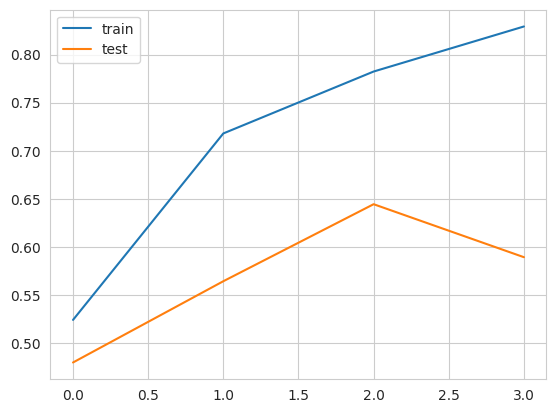

In [22]:
ins = Instructor(args, logger)
ins.run()

100%|██████████| 954/954 [00:32<00:00, 29.59it/s]


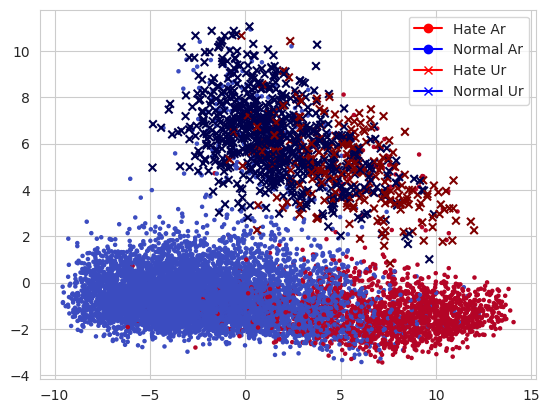

In [23]:
embeddings = []
predictions = []
for data in tqdm(train_data.text):  #which data to plot, test or train
  text_ids = ins.tokenizer([data],
                          padding=True,
                          truncation=True,
                          max_length=256,
                          is_split_into_words=True,
                          add_special_tokens=True,
                          return_tensors='pt').to(torch.device('cuda'))
  embd = ins.model.forward_only_base(text_ids.input_ids, text_ids.attention_mask)
  embd = embd.cpu().detach().numpy()[0]
  embeddings.append(embd)

  pred = ins.model.forward(text_ids.input_ids, text_ids.attention_mask)
  pred = pred['predicts'].cpu().detach().numpy()[0]
  predictions.append(pred)


lsl = len(embeddings)
for data in tqdm(test_data.text):  #which data to plot, test or train
  text_ids = ins.tokenizer([data],
                          padding=True,
                          truncation=True,
                          max_length=256,
                          is_split_into_words=True,
                          add_special_tokens=True,
                          return_tensors='pt').to(torch.device('cuda'))
  embd = ins.model.forward_only_base(text_ids.input_ids, text_ids.attention_mask)
  embd = embd.cpu().detach().numpy()[0]
  embeddings.append(embd)

  pred = ins.model.forward(text_ids.input_ids, text_ids.attention_mask)
  pred = pred['predicts'].cpu().detach().numpy()[0]
  predictions.append(pred)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=75, random_state=10).fit_transform(np.array(embeddings))
embeddings = PCA(n_components=2, random_state=41).fit_transform(np.array(embeddings))


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import seaborn as sns
sns.set_style('whitegrid')

handles = [
    Line2D([0], [0], marker='o', color='r', label='Hate Ar'),
    Line2D([0], [0], marker='o', color='b', label='Normal Ar'),
    Line2D([0], [0], marker='x', color='r', label='Hate Ur'),
    Line2D([0], [0], marker='x', color='b', label='Normal Ur'),
]
labels = ['Hate Ar', 'Normal Ar', 'Hate Ur', 'Normal Ur']
sl = split_len

# plt.title('CE: Fewshot Cross-Lingual Ar-Ur')
plt.scatter(embeddings[:lsl, 0], embeddings[:lsl, 1], c=train_data.hs, marker='o', cmap='coolwarm', s=5)
plt.scatter(embeddings[lsl:, 0], embeddings[lsl:, 1], c=test_data.hs, marker='x', cmap='seismic', s=30)
plt.legend(handles=handles, labels=labels)
plt.show()

In [24]:
preds_dict = {}
answers = test_data.iloc[np.where(np.array(predictions[lsl:]).argmax(axis=1) != test_data['hs'])]
preds_dict['CE'] = answers

In [25]:
preds_dict

{'CE':       index                                               text hs
 2452   3566  is salman se koi ye to puchho ki mahira or aar...  1
 4331   6205            randi ourat is mari hoi ko to bakhsh do  1
 1453   2133  me ne socha tha tm ek achy journalist ho gy mg...  1
 4543   6507   teri chut me sabhi bhaiyo ka lund reply de randi  1
 3708   5322  ye halala gang ko pata hi nahi hoga ki abbu ka...  1
 ...     ...                                                ... ..
 3838   5506  aishe ghosh ko bol de agar awkat nai hai fees ...  1
 3845   5515  kyu harami insaan k bare me soch kar apna time...  1
 2112   3065  tu khandani ghasti hai to bolti ra tery lye ma...  1
 4050   5800     ye sa**i toh pakka kisi halala ki paidaish hai  1
 4643   6646  ab ye wahn bhi ghasety jayengy ia allah pak ny...  1
 
 [200 rows x 3 columns]}

In [26]:
preds_dict['CE'].to_csv('/content/gdrive/MyDrive/UrduPredsCE.csv')